# Exploration of Central Valley LST & In Situ Data
This notebook explores the availability and suitability of data from in situ meteorological towers located in the Central Valley of California to support evaluation of Land Surface Temperature (LST) and related products from the Hydrosat Fusion Hub.

In [1]:
import base64
from datetime import datetime
import json
import os
os.environ['USE_PYGEOS'] = '0'
import requests

from pprint import pprint

from botocore.exceptions import ClientError


from FH_Hydrosat import FH_Hydrosat
from FH_Hydrosat import FH_StackedDataset
import folium
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import numpy as np
import pystac
from pystac_client import Client
from pyproj.crs import CRS
import rioxarray as rxr
import seaborn as sns
from shapely.geometry import box, mapping, Point, Polygon
import rasterio as rio
import xarray as xr

## In Situ Data
Three meterorological towers from the [AmeriFlux](https://ameriflux.lbl.gov/) network were identified in the Central Valley of California. Data for each site were downloaded as `.csv` and uploaded as a zip file to the project Drive, [here](https://drive.google.com/file/d/1GaqWZ1_zzaIoQ96yRbp0WLHZFhS3BlGd/view?usp=share_link). Data are also available in the `data` folder of this repository. Sites include:   
- [US-DS3: Staten Rice 1](https://ameriflux.lbl.gov/sites/siteinfo/US-DS3) (38.1235, -121.5490)
- [US-Bi2: Bouldin Island corn](https://ameriflux.lbl.gov/sites/siteinfo/US-Bi2) (38.1091, -121.5351)
- [US-Bi1: Bouldin Island Alfalfa](https://ameriflux.lbl.gov/sites/siteinfo/US-Bi1) (38.0992, -121.4993)

*Funding for the AmeriFlux data portal was provided by the U.S. Department of Energy Office of Science. Citations for each site, including the data-product DOI, are available in `data/Ameriflux/citations_for_site_data_BASE-BADM_20230409.csv`.*

Ameriflux data include many variables for comparison with LST, including
- T_CANOPY: Temperature of the canopy and/or surface underneath the sensor
- RH: Relative humidity, range 0-100
- TA: Air temperature
- VPD: Vapor pressure deficit
- NDVI: Normalized Difference Vegetation Index
- TS: Soil temperature

All variable definitions can be found in `data/flux-met-processing-variables_20230409.csv`.

However, not all sites include all variables. Next we evaluate each site for the (1) temporal scale and (2) availability of data for these potentially important variables.


<AxesSubplot:>

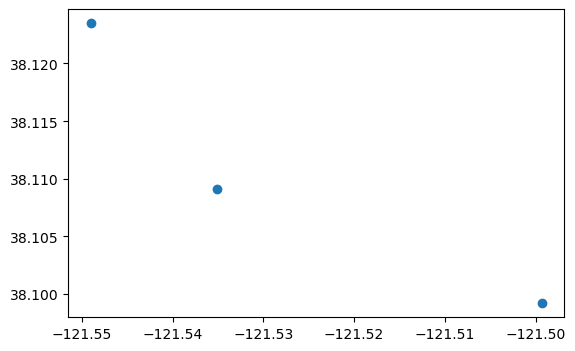

In [2]:
# Create gdf of insitu point locations
insitu_points = {
    'Rice': [38.1235, -121.5490],
    'Corn': [38.1091, -121.5351],
    'Alfalfa': [38.0992, -121.4993]
}

insitu_df = pd.DataFrame.from_dict(insitu_points,
                                   orient='index',
                                   columns=['lat', 'lon'])
insitu_gdf = gpd.GeoDataFrame(
    insitu_df, 
    geometry=gpd.points_from_xy(insitu_df.lon, insitu_df.lat),
    crs=CRS.from_epsg(4326))
insitu_gdf.plot()

In [3]:
# Create aoi geodataframe by buffering points by 100m
aoi_gdf = gpd.GeoDataFrame(
    geometry=[box(*insitu_gdf.total_bounds)], 
    crs=CRS.from_epsg(4326))
raster_crs = CRS.from_epsg(32610)
buffer_dist = 1000
aoi_gdf = aoi_gdf.to_crs(raster_crs).buffer(buffer_dist, cap_style = 3) # square buffer

In [4]:
# Map the bounding box and points
m = folium.Map(
    location=[insitu_gdf.geometry.y.mean(), insitu_gdf.geometry.x.mean()],
    zoom_start=13, tiles='Stamen Terrain',
    scrollWheelZoom=False)

sim_geo = aoi_gdf.to_crs(CRS.from_epsg(4326)).simplify(tolerance=0.001)
geo_j = gpd.GeoSeries(sim_geo).to_json()
geo_j = folium.GeoJson(data=geo_j,
                       style_function=lambda x: {'fillColor': 'red'})
geo_j.add_to(m)

for point in insitu_points:
    lat = insitu_points.get(point)[0]
    lon = insitu_points.get(point)[1]

    folium.Marker(location=[lat, lon]).add_to(m)

m

In [5]:
# Define paths to data
data_path = os.path.join('../data', 'Ameriflux')
bi1_data_path = os.path.join(data_path, 
                             'AMF_US-Bi1_BASE-BADM_8-5',
                             'AMF_US-Bi1_BASE_HH_8-5.csv')
bi2_data_path = os.path.join(data_path,
                             'AMF_US-Bi2_BASE-BADM_13-5',
                             'AMF_US-Bi2_BASE_HH_13-5.csv')
ds3_data_path = os.path.join(data_path,
                             'AMF_US-DS3_BASE-BADM_1-5',
                             'AMF_US-DS3_BASE_HH_1-5.csv')

In [6]:
# Define variables of interest
interest_vars = ['T_CANOPY', 'RH', 'TA', 'VPD', 'NDVI', 'EVI', 'TS']

In [7]:
# Define function to process Ameriflux data
def read_ameriflux(data_path):
    df = pd.read_csv(data_path, header=2, na_values=[-9999])

    # Save value column names
    value_cols = df.columns[2:]

    # Convert timestamp objects
    df['start'] = df['TIMESTAMP_START'].apply(
        lambda x: datetime.strptime(str(x), "%Y%m%d%H%M")
        )
    df['end'] = df['TIMESTAMP_END'].apply(
        lambda x: datetime.strptime(str(x), "%Y%m%d%H%M")
        )

    # Drop NA
    df = df.dropna(subset=value_cols, how='all')

    df = df.set_index('start')
    col_order = (['end', 'TIMESTAMP_START', 'TIMESTAMP_END'] 
                 + value_cols.to_list())
    df = df[col_order]

    return df


Data range from 2016-08-13 00:00:00 to 2022-05-26 23:30:00


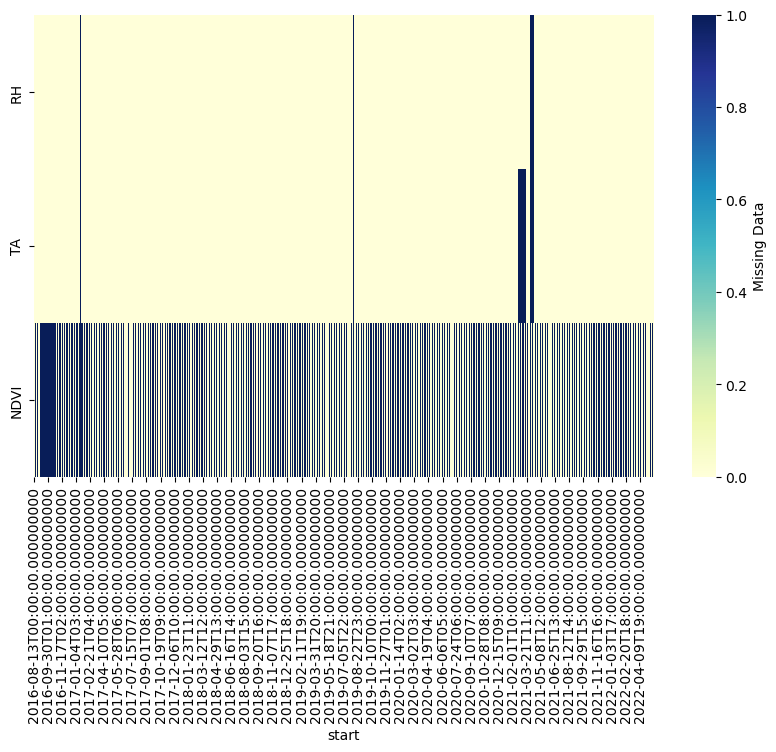

In [8]:
# Explore bi1 data
bi1_df = read_ameriflux(bi1_data_path)
print(f'Data range from {bi1_df.index.min()} to {bi1_df.index.max()}')
bi1_var_cols = [var for var in interest_vars 
                if bi1_df.columns.to_list().count(var) > 0]
if len(bi1_var_cols) > 0:
    plt.figure(figsize=(10,6))
    sns.heatmap(bi1_df[bi1_var_cols].isna().transpose(),
                cmap="YlGnBu",
                cbar_kws={'label': 'Missing Data'})


<AxesSubplot:xlabel='start', ylabel='TA'>

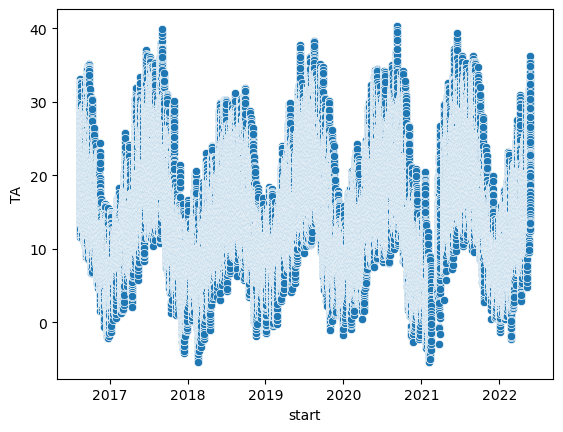

In [9]:
sns.scatterplot(bi1_df['TA'])

Data range from 2017-04-27 00:00:00 to 2022-05-26 23:30:00


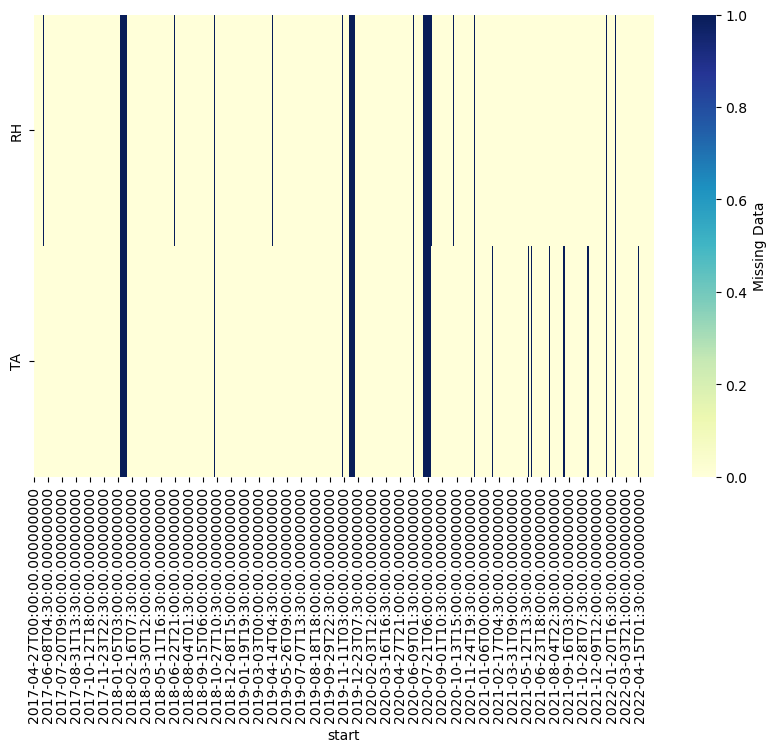

In [10]:
# Explore bi2 data
bi2_df = read_ameriflux(bi2_data_path)
print(f'Data range from {bi2_df.index.min()} to {bi2_df.index.max()}')
bi2_var_cols = [var for var in interest_vars 
                if bi2_df.columns.to_list().count(var) > 0]
if len(bi2_var_cols) > 0:
    plt.figure(figsize=(10,6))
    sns.heatmap(bi2_df[bi2_var_cols].isna().transpose(),
                cmap="YlGnBu",
                cbar_kws={'label': 'Missing Data'})

In [11]:
# Explore ds3 data
ds3_df = read_ameriflux(ds3_data_path)
print(f'Data range from {ds3_df.index.min()} to {ds3_df.index.max()}')
ds3_var_cols = [var for var in interest_vars if ds3_df.columns.to_list().count(var) > 0]
if len(ds3_var_cols) > 0:
    plt.figure(figsize=(10,6))
    sns.heatmap(ds3_df[ds3_var_cols].isna().transpose(),
                cmap="YlGnBu",
                cbar_kws={'label': 'Missing Data'})


Data range from 2021-08-04 00:00:00 to 2022-08-31 23:30:00


### In situ data discussion
Of the three sites, BI-1 may be the best for initial comparison with LST. BI-1 has temporal coverage from 08/13/2016 through 05/26/2022 at 30-minute grain, giving us five full growing seasons. 

BI-2 does not include tower NDVI and DS-3 does not include any variables of interest.

## Hydrosat Fusion Hub LST Data

In [12]:
# Authenticate and access catalog
with open(os.path.join('../secrets', 'creds.json')) as f:
    creds = json.loads(f.read())
    
userpass = f"{creds['username']}:{creds['password']}"
b64 = base64.b64encode(userpass.encode()).decode()
headers = {'Authorization':'Basic ' + b64}

cat_url = 'https://fusion-stac.hydrosat.com'
catalog = Client.open(cat_url, headers)

In [13]:
# Print available collections to file
available_collections = catalog.get_children()
if not os.path.exists('available_collections.txt'):
    with open('available_collections.txt', 'w') as f:
        for collection in available_collections:
            f.write(f"{collection.id} - {collection.title}\n")

In [14]:
# Search selected collections
collections = ["starfm_predictions_modis_landsat", "pydms_sharpened_landsat"]
start_date = "2016-08-13T00:00:00Z"
end_date = "2022-05-26T00:00:00Z"

search = catalog.search(
    collections = collections,
    intersects = box(*aoi_gdf.to_crs(CRS.from_epsg(4326)).total_bounds),
    datetime = [start_date, end_date],
    max_items = 500
)
returned_items = search.get_all_items()

In [16]:
# Print returned items to file
if not os.path.exists('returned_items.json'):
    with open('returned_items.json', 'w') as f:
        itemjson = json.dumps(returned_items.to_dict(), indent=4)
        f.write(itemjson)

In [17]:
# Order returned items sequentially
# items = list(search.items()) # for pystac-client >= 0.4.0
items = list(returned_items) # for pystac-client < 0.4.0
items.reverse() # make the results ascending in time
len(items)

488

In [18]:
# Confirm results are within a single MGRS tile
mgrs_tiles = []
for i in items:
    for l in i.to_dict()['links']:
        if 'element84' in l['href']:
            mgrs_tiles.append(l['href'].split(r'/')[-1].split('_')[1])
print(f'number of tiles in query: {len(set(mgrs_tiles))}, {set(mgrs_tiles)}')

# if there is more than one tile, uncomment and execute this next line to choose the MGRS tile you are interested in
# items = [i for i in items if mgrs_tiles[0] in i.id]

number of tiles in query: 1, {'10SFH'}


In [48]:
# Convert to data array
res = FH_Hydrosat(items[400:])
stacked_res = res.stack()
ds = stacked_res.ds.sortby('time')
ds

<xarray.DataArray (time: 88, band: 1, y: 5490, x: 5490)>
dask.array<concatenate, shape=(88, 1, 5490, 5490), dtype=float32, chunksize=(1, 1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05 7.098e+05
  * y            (y) float64 4.3e+06 4.3e+06 4.3e+06 ... 4.19e+06 4.19e+06
    spatial_ref  int32 0
  * time         (time) object 2022-02-27T00:00:00+00:00 ... 2022-05-26T00:00...
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  NEAREST
    _FillValue:          nan
    scale_factor:        1.0
    add_offset:          0.0

In [49]:
# clip the raster dataset and cast to a class with slightly more functions
clipped = FH_StackedDataset(ds.rio.clip(aoi_gdf.geometry))
ds_clip = clipped.ds
ds_clip

<xarray.DataArray (time: 88, band: 1, y: 238, x: 320)>
dask.array<getitem, shape=(88, 1, 238, 320), dtype=float32, chunksize=(1, 1, 174, 320), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 6.262e+05 6.262e+05 ... 6.326e+05 6.326e+05
  * y            (y) float64 4.222e+06 4.222e+06 ... 4.217e+06 4.217e+06
  * time         (time) object 2022-02-27T00:00:00+00:00 ... 2022-05-26T00:00...
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  NEAREST
    scale_factor:        1.0
    add_offset:          0.0
    _FillValue:          nan

In [50]:
# ax = ds_clip.plot(x='x', y='y', col='time', col_wrap=5)
# ax.set_xlabels('Easting [m]')
# ax.set_ylabels('Northing [m]')
# for _, row in insitu_gdf.to_crs(raster_crs).iterrows():
#    ax.map(lambda: plt.plot(row.geometry.x, row.geometry.y, markersize=10, marker=".", color="k")) 
# plt.show()

In [51]:
# fig, ax = plt.subplots(figsize=(11,3))
# for idx, row in insitu_gdf.to_crs(raster_crs).iterrows():
#    ax = (ds_clip
#          .isel(band=0)
#          .sel(x=row.geometry.x, y=row.geometry.y, 
#               method='nearest', tolerance=20)
#          .plot(marker='o', label=idx))
# plt.title(f'Time Series for In Situ Tower Locations')
# plt.grid(True)
# plt.ylabel('Fused LST [K]')
# plt.xticks(rotation=45)
# plt.legend()
# plt.show()

In [52]:
# bs1_point = insitu_gdf.to_crs(raster_crs).loc['Alfalfa']
# bs1_series = (ds_clip
#               .isel(band=0)
#               .sel(x=bs1_point.geometry.x, y=bs1_point.geometry.y, 
#               method='nearest', tolerance=20))
# bs1_series

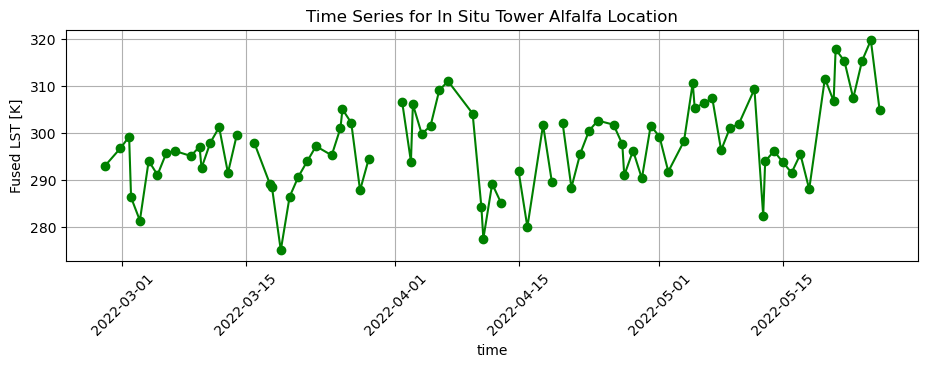

In [53]:
bs1_point = insitu_gdf.to_crs(raster_crs).loc['Alfalfa']
fig, ax = plt.subplots(figsize=(11, 3))
ax = (ds_clip
     .isel(band=0)
     .sel(x=bs1_point.geometry.x, y=bs1_point.geometry.y,
          method='nearest', tolerance=20)
     .plot(marker='o', color='g'))
plt.title(f'Time Series for In Situ Tower Alfalfa Location')
plt.grid(True)
plt.ylabel('Fused LST [K]')
plt.xticks(rotation=45)
# plt.legend()
plt.show()

In [47]:
from dask.distributed import Client

client = Client()
client.cluster